In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# key directories
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
import illustris_python as il
import Corrfunc
from Corrfunc.theory.xi import xi
import os
import sys
sys.path.insert(0, work)
import corrfunc_ls
from illustris_sim import IllustrisSim
from illustris_xi import compute_xi_auto_illustris
import tools

We want to compute the cross-correlation between DM particles (this is the "true" underlying density field) and galaxies (a single position for each galaxy -> these are the subfind subhalos from the Illustris group catalogs).

#### parameters

In [4]:
z = 0.
# initialize simulation and snapshot
sim = IllustrisSim('TNG300-3')
sim.set_snapshot(redshift=z)

#### DM particles

In [5]:
sim.load_dm_pos()

In [6]:
sim.dm_pos.shape

(244140625, 3)

#### galaxies

In [7]:
sim.load_gal_pos()
sim.gal_pos.shape

(391144, 3)

#### get subsample of each data set

In [8]:
dm_subsample = tools.get_subsample(sim.dm_pos, nx=100)
gal_subsample = tools.get_subsample(sim.gal_pos, nx=100)

subsampling 2441406 random particles...
subsampling 1354 random particles...


#### compute cross-correlation

In [13]:
# gal_subsample is the "data set," while dm_subsample is the "tracer set"
# we want to get the random set from the tracers
# set up data for the calculation
randmult = 3
rmin = 1.
rmax = 50.
nbins = 10
tracersforcf = corrfunc_ls.set_up_cf_data(dm_subsample.value, randmult, rmin, rmax, nbins, logbins=True, dtype='float32')
r_edges, r_avg, nd, boxsize, nr, rand_set, tracer_set = tracersforcf.values()

In [18]:
# unpack data
xgal, ygal, zgal = gal_subsample.value.T
xdm, ydm, zdm = tracer_set.T
xr, yr, zr = rand_set.T

In [17]:
%%time
# the calculation should be mostly the same, but DD should involve the galaxy set and the DM set
nthreads = 12
periodic = True
results_DD = Corrfunc.theory.DD(0, nthreads, r_edges, xgal, ygal, zgal, X2=xdm, Y2=ydm, Z2=zdm,
                                boxsize=boxsize, periodic=periodic)

CPU times: user 855 ms, sys: 56.5 ms, total: 911 ms
Wall time: 953 ms


In [19]:
%%time
results_DR = Corrfunc.theory.DD(0, nthreads, r_edges, xgal, ygal, zgal, X2=xr, Y2=yr, Z2=zr,
                                boxsize=boxsize, periodic=periodic)

CPU times: user 1.92 s, sys: 30.5 ms, total: 1.95 s
Wall time: 196 ms


In [20]:
%%time
results_RR = Corrfunc.theory.DD(1, nthreads, r_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

CPU times: user 31min 13s, sys: 278 ms, total: 31min 13s
Wall time: 2min 36s


In [27]:
rr_save_fn = os.path.join(scratch, f'xi/rr_3x-DM-100x-subsample_z-{z:.1f}-{sim.sim}.npy')
np.save(rr_save_fn, results_RR)

In [21]:
dd = np.array([x['npairs'] for x in results_DD], dtype=float)
dr = np.array([x['npairs'] for x in results_DR], dtype=float)
rr = np.array([x['npairs'] for x in results_RR], dtype=float)

In [26]:
nd, nr, nr/nd

(2441406, 7324218, 3.0)

In [28]:
len(gal_subsample), len(dm_subsample)

(1354, 2441406)

In [29]:
results_xi = Corrfunc.utils.convert_3d_counts_to_cf(len(gal_subsample), nd, nr, nr, dd, dr, dr, rr)

In [30]:
results_xi.shape

(10,)

Text(0, 0.5, '$\\xi(r)$')

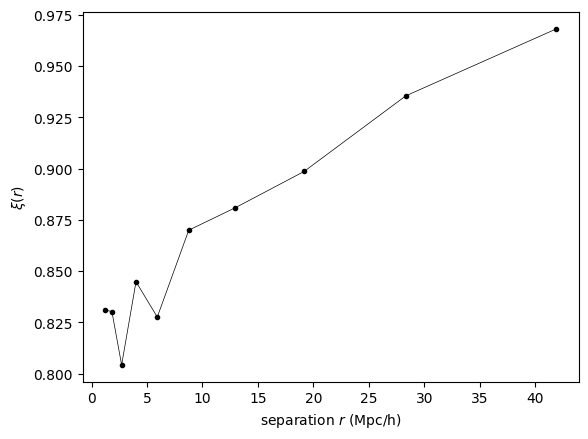

In [35]:
fig, ax = plt.subplots()
ax.plot(r_avg, results_xi, 'k.-', lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')

### galaxy autocorrelation

In [8]:
sim.gal_pos.shape

(391144, 3)

In [10]:
randmult = 3
rmin = 0.1
rmax = 50.  
nbins = 20
subsample_nx = 100
nthreads = 12

In [12]:
%%time
result = compute_xi_auto_illustris(sim.sim, z, 'gal', randmult, rmin, rmax, nbins,
                            subsample_nx=subsample_nx, nthreads=nthreads, save_fn=None, return_res=True)

subsampling 3911 random particles...
CPU times: user 609 ms, sys: 13.2 ms, total: 623 ms
Wall time: 190 ms


In [13]:
fig, ax = plt.subplots()
ax.plot(r_avg, results_xi, 'k.-', lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')

{'ravg': array([ 0.11822107,  0.16130334,  0.22008572,  0.30028966,  0.40972161,
         0.55903291,  0.76275642,  1.04072114,  1.41998212,  1.93745389,
         2.64350341,  3.60685244,  4.92126641,  6.71468086,  9.16165379,
        12.50035585, 17.05575215, 23.27123204, 31.75176538, 43.32278596]),
 'xi': array([            nan,             nan,             nan,  3.70000000e+01,
         2.65000000e+01,  7.60000000e+01,  1.25384615e+01,  4.13636364e+00,
         2.01941748e+00,  1.47761194e+00,  1.87431694e+00,  8.42105263e-01,
         6.66135458e-01,  3.41658662e-01,  1.85390929e-01,  1.62139261e-01,
         5.93093628e-02,  2.86033690e-02,  9.92558815e-03, -2.46921179e-03]),
 'rmin': 0.1,
 'rmax': 50.0,
 'nbins': 20,
 'logbins': True,
 'periodic': True,
 'nthreads': 12,
 'redshift': 0.0,
 'data': array([[193.9267  , 194.75084 , 148.38771 ],
        [ 39.857548,  69.90597 ,  79.064476],
        [ 28.94503 ,  46.4874  , 197.09898 ],
        ...,
        [ 50.58074 , 130.60167 ,  58